Importing all the libraries I need for data analysis and modeling.



In [1]:
#Imports

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

Loading the cleaned diabetes dataset and checking the first few rows.

In [2]:
# Load Data
path='/content/diabetes_cleaned.csv'
df=pd.read_csv(path)
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,...,1,0,5.0,18.0,15.0,1,0,9.0,4.0,3.0
1,0,0,0,0,25.0,1,0,0,1,0,...,0,1,3.0,0.0,0.0,0,0,7.0,6.0,1.0
2,0,1,1,1,28.0,0,0,0,0,1,...,1,1,5.0,30.0,30.0,1,0,9.0,4.0,8.0
3,0,1,0,1,27.0,0,0,0,1,1,...,1,0,2.0,0.0,0.0,0,0,11.0,3.0,6.0
4,0,1,1,1,24.0,0,0,0,1,1,...,1,0,2.0,3.0,0.0,0,0,11.0,5.0,4.0


Selecting key features and checking multicollinearity using VIF.

In [4]:
#select subset of features
selected_features = ['HighBP','BMI','GenHlth','Age']

df_X=df[selected_features]

#compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df_X.columns
vif_data["VIF"] = [variance_inflation_factor(df_X.values,i) for i in range(len(df_X.columns))]
print(vif_data)

   feature       VIF
0   HighBP  2.156648
1      BMI  8.573079
2  GenHlth  7.286005
3      Age  6.547596


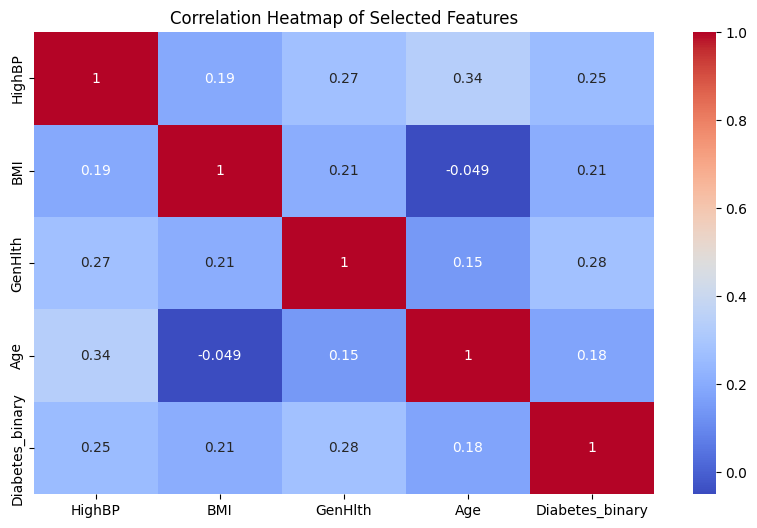

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['HighBP','BMI','GenHlth','Age','Diabetes_binary']].corr(),annot=True,cmap="coolwarm")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

Building a basic linear regression model with selected features.

In [7]:
model_basic = smf.ols(formula='Diabetes_binary ~ HighBP + BMI + GenHlth + Age',data=df)
results_basic = model_basic.fit()
print(results_basic.params)
print(results_basic.summary())

Intercept   -0.383968
HighBP       0.098485
BMI          0.007615
GenHlth      0.065516
Age          0.012770
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Diabetes_binary   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     9126.
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:54:49   Log-Likelihood:                -74187.
No. Observations:              229474   AIC:                         1.484e+05
Df Residuals:                  229469   BIC:                         1.484e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

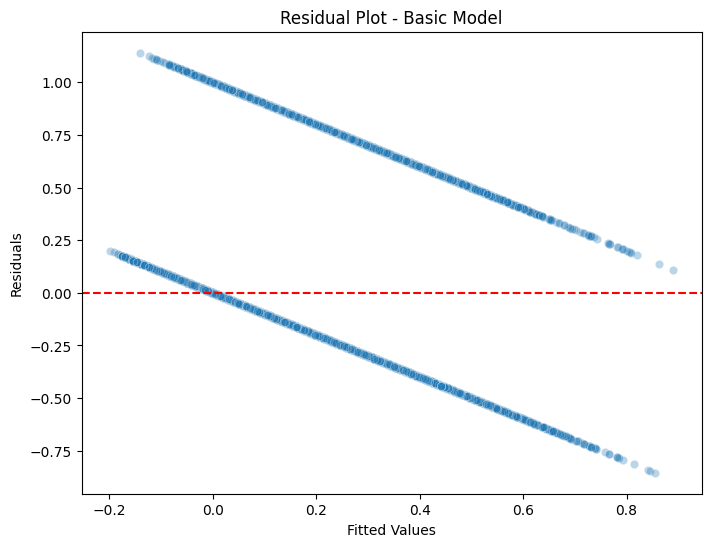

In [8]:


residuals = results_basic.resid
fitted = results_basic.fittedvalues

plt.figure(figsize=(8,6))
sns.scatterplot(x=fitted,y=residuals,alpha=0.3)
plt.axhline(0,color='red',linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Basic Model")
plt.show()


Adding a polynomial term (BMI^2) to capture non-linear effects.




In [9]:
model_poly = smf.ols(formula='Diabetes_binary ~ HighBP + BMI + GenHlth + Age + I(BMI**2)',data=df)
results_poly = model_poly.fit()
print(results_poly.params)

Intercept     -0.565348
HighBP         0.094103
BMI            0.018731
GenHlth        0.064631
Age            0.012890
I(BMI ** 2)   -0.000154
dtype: float64


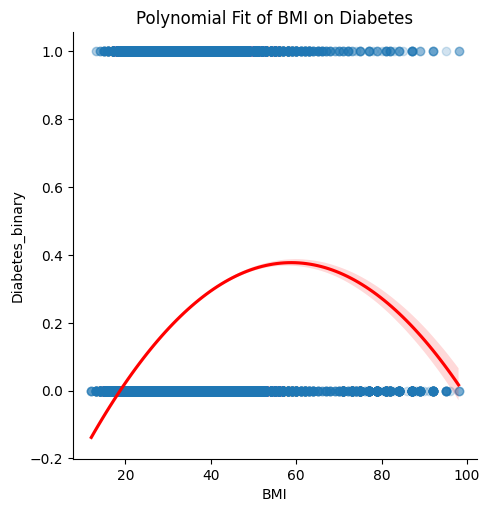

In [10]:
sns.lmplot(x="BMI",y="Diabetes_binary",data=df,
           order=2,scatter_kws={'alpha':0.2},line_kws={"color":"red"})
plt.title("Polynomial Fit of BMI on Diabetes")
plt.show()


Adding an interaction term ( HighBP x BMI ) to see combined effects.

In [11]:
model_inter = smf.ols(formula='Diabetes_binary ~ HighBP * BMI + GenHlth + Age',data=df)
results_inter = model_inter.fit()
print(results_inter.params)

Intercept    -0.283153
HighBP       -0.122205
BMI           0.003838
HighBP:BMI    0.007626
GenHlth       0.065382
Age           0.013233
dtype: float64


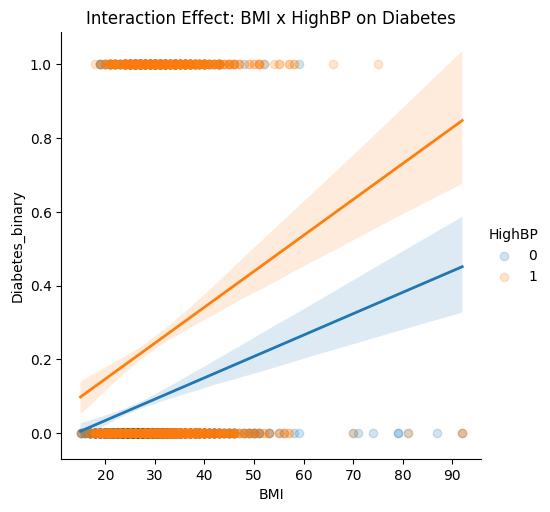

In [15]:
sns.lmplot(x="BMI",y="Diabetes_binary",hue="HighBP",data=df.sample(5000),
           scatter_kws={'alpha':0.2},line_kws={"lw":2})
plt.title("Interaction Effect: BMI x HighBP on Diabetes")
plt.show()


Using cross validation ( 5-fold ) to compare model performance ( RMSE ).

In [17]:
kf = KFold(n_splits=5,shuffle=False)

def compute_cv_rmse(formula):
    rmse_list = []
    for train_index,test_index in kf.split(df):
        model = smf.ols(formula=formula,data=df.iloc[train_index])
        results = model.fit()
        prediction = results.predict(df.iloc[test_index])
        rmse = root_mean_squared_error(df.iloc[test_index]['Diabetes_binary'],prediction)
        rmse_list.append(rmse)
    return np.mean(rmse_list)

rmse_basic = compute_cv_rmse('Diabetes_binary ~ HighBP + BMI + GenHlth + Age')
rmse_poly = compute_cv_rmse('Diabetes_binary ~ HighBP + BMI + GenHlth + Age + I(BMI**2)')
rmse_inter = compute_cv_rmse('Diabetes_binary ~ HighBP * BMI + GenHlth + Age')

print("CV RMSE for Basic Model:",rmse_basic)
print("CV RMSE for Polynomial Model:",rmse_poly)
print("CV RMSE for Interaction Model:",rmse_inter)

CV RMSE for Basic Model: 0.33449615640390246
CV RMSE for Polynomial Model: 0.3338300245683071
CV RMSE for Interaction Model: 0.3334913679374635


Creating BMI and Age groups to visualize diabetes prevalence.

In [18]:
df2 = df.copy()
df2["BMI_bin"] = pd.cut(df2.BMI,bins=3)
df2["Age_bin"] = pd.cut(df2.Age,bins=3)
df2["Y"] = df2.Diabetes_binary
pivot = pd.pivot_table(data=df2,index="BMI_bin",columns="Age_bin",values="Y",aggfunc="mean")
print(pivot)

Age_bin           (0.988, 5.0]  (5.0, 9.0]  (9.0, 13.0]
BMI_bin                                                
(11.914, 40.667]      0.037765    0.137418     0.209705
(40.667, 69.333]      0.167518    0.375661     0.492689
(69.333, 98.0]        0.061611    0.160584     0.210526


/tmp/ipython-input-2836636466.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(data=df2,index="BMI_bin",columns="Age_bin",values="Y",aggfunc="mean")


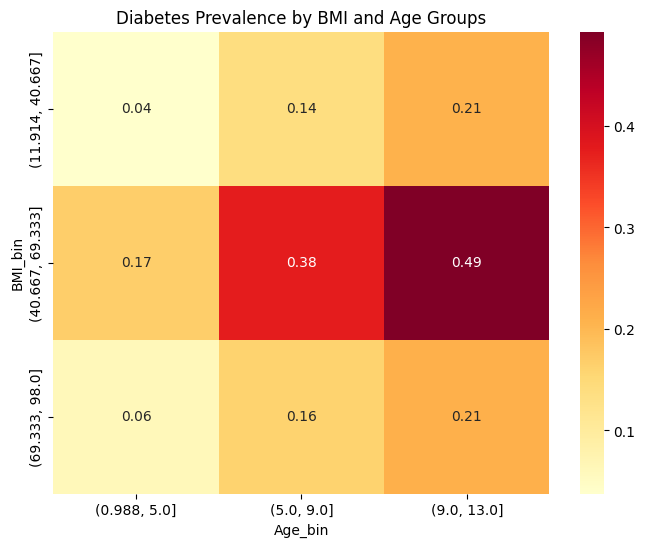

In [19]:
plt.figure(figsize=(8,6))
sns.heatmap(pivot,annot=True,cmap="YlOrRd",fmt=".2f")
plt.title("Diabetes Prevalence by BMI and Age Groups")
plt.show()


One-hot encoding categorical feature (Education) for regression use.

In [20]:
df_onehot = pd.get_dummies(df,columns=['Education'],prefix='Edu')
print(df_onehot.head())

   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                0       1         1          1  40.0       1       0   
1                0       0         0          0  25.0       1       0   
2                0       1         1          1  28.0       0       0   
3                0       1         0          1  27.0       0       0   
4                0       1         1          1  24.0       0       0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  DiffWalk  Sex   Age  \
0                     0             0       0  ...         1    0   9.0   
1                     0             1       0  ...         0    0   7.0   
2                     0             0       1  ...         1    0   9.0   
3                     0             1       1  ...         0    0  11.0   
4                     0             1       1  ...         0    0  11.0   

   Income  Edu_1.0  Edu_2.0  Edu_3.0  Edu_4.0  Edu_5.0  Edu_6.0  
0     3.0    False    False    False     Tru